Ordinary Differential Equations: Conversion Reaction
============================

This example provides a model for the interconversion of two species 
($X_1$ and $X_2$) following first-order mass action kinetics with the 
parameters $\Theta_1$ and $\Theta_2$ respectively:


$$
    X_1 \rightarrow X_2, \quad\text{rate} = \Theta_1 \cdot [X_1]
$$

$$
    X_2 \rightarrow X_1, \quad\text{rate} = \Theta_2 \cdot [X_2]
$$

Measurement of $[X_2]$ is provided as $Y = [X_2]$.

We will show how to estimate $\Theta_1$ and $\Theta_2$ using pyABC.

In [1]:
%matplotlib inline

import pyabc
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
import scipy as sp
import time

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

Data
----

We use an artificial data set which consists of a vector of time points $t$
and a measurement vector $Y$. This data was created using the parameter 
values which are assigned to $\Theta_{\text{true}}$ and by adding normaly distributed 
measurement noise with variance $\sigma^2 = 0.015^2$. 

ODE model
---------

$$
    \begin{align*}
    \frac{dX_1}{dt} &= -\Theta_1 \cdot X_1 + \Theta_2 \cdot X_2\\
    \frac{dX_2}{dt} &= \Theta_1 \cdot X_1 - \Theta_2 \cdot X_2
    \end{align*}
$$

Define the true parameters

In [2]:
theta1_true, theta2_true = np.exp([-2.5, -2])

and the measurement data

In [3]:
measurement_data = np.array([0.0244, 0.0842, 0.1208,
                             0.1724, 0.2315, 0.2634,
                             0.2831, 0.3084, 0.3079,
                             0.3097, 0.3324])

as well as the time points at whith to evaluate

In [4]:
measurement_times = np.arange(len(measurement_data))        

and the initial conditions for $X_1$ and $X_2$

In [5]:
init = np.array([1, 0])

Define the ODE model

In [6]:
def f(y, t0, theta1, theta2):
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2



def model(pars):
    sol = sp.integrate.odeint(
             f, init, measurement_times,
             args=(pars["theta1"],pars["theta2"]))
    noise_factor = 0.025
    noise = noise_factor*np.random.normal(0,1,len(sol[:,1]))
    return {"X_2": sol[:,1]+noise}

Integration of the ODE model for the true parameter values

In [7]:
true_trajectory = model({"theta1": theta1_true,
                         "theta2": theta2_true})["X_2"]

Let's visualize the results

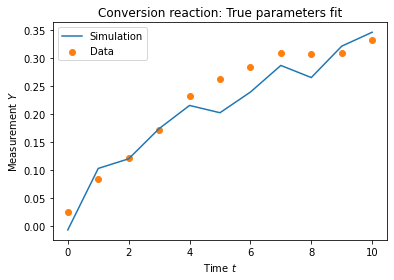

In [8]:
plt.plot(true_trajectory, color="C0", label='Simulation')
plt.scatter(measurement_times, measurement_data,
            color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: True parameters fit')
plt.legend()
plt.show()

In [9]:
def distance(simulation, data):
    return np.absolute(data["X_2"] - simulation["X_2"]).sum()

Define the prior for $\Theta_1$ and $\Theta_2$

In [10]:
parameter_prior = pyabc.Distribution(theta1=pyabc.RV("uniform", 0, 1),
                               theta2=pyabc.RV("uniform", 0, 1))
parameter_prior.get_parameter_names()

eps_list=[10, 5, 3, 2, 1, 0.75, 0.5, 0.33, 0.25]
eps = pyabc.ListEpsilon(eps_list),
#eps=pyabc.MedianEpsilon(500, median_multiplier=0.8)
pop_size = 5000
min_eps=0.21

In [11]:
redis_sampler = pyabc.sampler.RedisEvalParallelSampler(host="localhost", port=6379, look_ahead = True)
abc = pyabc.ABCSMC(models=model,
        parameter_priors=parameter_prior,
        distance_function=distance,
        population_size=pop_size,
        sampler=redis_sampler,
        transitions=pyabc.LocalTransition(k_fraction=.3),
        eps=eps)

abc.new(db_path, {"X_2": measurement_data});
h = abc.run(minimum_epsilon=min_eps, max_nr_populations=len(eps_list))

INFO:History:Start <ABCSMC(id=6, start_time=2020-11-16 12:15:35.883208, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 5000 / 5007 = 9.9860e-01, ESS=5.0000e+03.
INFO:ABC:t: 1, eps: 1.8586430153095397.
INFO:ABC:Preliminary accepted: 5000;  Preliminary acceptance rate: 5000 / 12722 = 3.9302e-01
INFO:ABC:Preliminary discarded: 626
INFO:ABC:Acceptance rate: 5000 / 19232 = 2.5998e-01, ESS=4.8347e+03.
INFO:ABC:t: 2, eps: 0.8036927132899419.
INFO:ABC:Preliminary accepted: 5000;  Preliminary acceptance rate: 5000 / 15074 = 3.3170e-01
INFO:ABC:Preliminary discarded: 616
INFO:ABC:Acceptance rate: 5000 / 22577 = 2.2146e-01, ESS=4.8229e+03.
INFO:ABC:t: 3, eps: 0.49460635272283693.
INFO:ABC:Preliminary accepted: 2822;  Preliminary acceptance rate: 2822 / 17119 = 1.6485e-01
INFO:ABC:Acceptance rate: 5000 / 30489 = 1.6399e-01, ESS=4.6878e+03.
INFO:ABC:t: 4, eps: 0.32931005124795654.
INFO:ABC:Preliminary accepted: 2481;  Preliminary acceptance rate: 2481 / 15506 = 1.6000e-01
INFO:A

In [12]:
redis_sampler = pyabc.sampler.RedisEvalParallelSampler(host="localhost", port=6379, look_ahead = False)
abc = pyabc.ABCSMC(models=model,
        parameter_priors=parameter_prior,
        distance_function=distance,
        population_size=pop_size,
        sampler=redis_sampler,
        transitions=pyabc.LocalTransition(k_fraction=.3),
        eps=eps)

abc.new(db_path, {"X_2": measurement_data});
h_old = abc.run(minimum_epsilon=min_eps, max_nr_populations=len(eps_list))

INFO:History:Start <ABCSMC(id=7, start_time=2020-11-16 12:19:03.387376, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 5000 / 5007 = 9.9860e-01, ESS=5.0000e+03.
INFO:ABC:t: 1, eps: 1.8549929255785589.
INFO:ABC:Acceptance rate: 5000 / 12603 = 3.9673e-01, ESS=4.8705e+03.
INFO:ABC:t: 2, eps: 0.8097164317745013.
INFO:ABC:Acceptance rate: 5000 / 14555 = 3.4352e-01, ESS=4.7917e+03.
INFO:ABC:t: 3, eps: 0.4968380704478954.
INFO:ABC:Acceptance rate: 5000 / 31732 = 1.5757e-01, ESS=4.6682e+03.
INFO:ABC:t: 4, eps: 0.3273840277957749.
INFO:ABC:Acceptance rate: 5000 / 31853 = 1.5697e-01, ESS=4.8026e+03.
INFO:ABC:t: 5, eps: 0.22443367122445626.
INFO:ABC:Acceptance rate: 5000 / 57011 = 8.7702e-02, ESS=2.2213e+03.
INFO:ABC:t: 6, eps: 0.1613144256214716.
INFO:ABC:Acceptance rate: 5000 / 289709 = 1.7259e-02, ESS=3.6488e+03.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=7, start_time=2020-11-16 12:19:03.387376, end_time=2020-11-16 12:22:10.631265)>


Visualization of the probability density functions for $\Theta_1$ and $\Theta_2$

ValueError: num must be 1 <= num <= 6, not 7

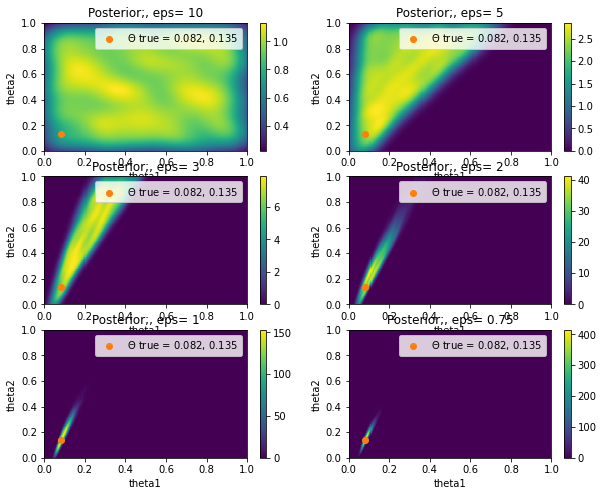

In [14]:
fig = plt.figure(figsize=(10,8))
for t in range(h.max_t+1):
    ax = fig.add_subplot(3, np.ceil(h.max_t / 3), t+1)

    ax = pyabc.visualization.plot_kde_2d(
        *h.get_distribution(m=0, t=t), "theta1", "theta2",
        xmin=0, xmax=1, numx=200, ymin=0, ymax=1, numy=200, ax=ax)
    ax.scatter([theta1_true], [theta2_true], color="C1",
                label='$\Theta$ true = {:.3f}, {:.3f}'.format(
                    theta1_true, theta2_true))
    ax.set_title("Posterior;, eps= "+str(eps_list[t]).format(t))

    ax.legend()
fig.tight_layout()
plt.savefig("/home/felipe/MTGraphics/NoisyHeatmap.jpg")

ValueError: num must be 1 <= num <= 6, not 7

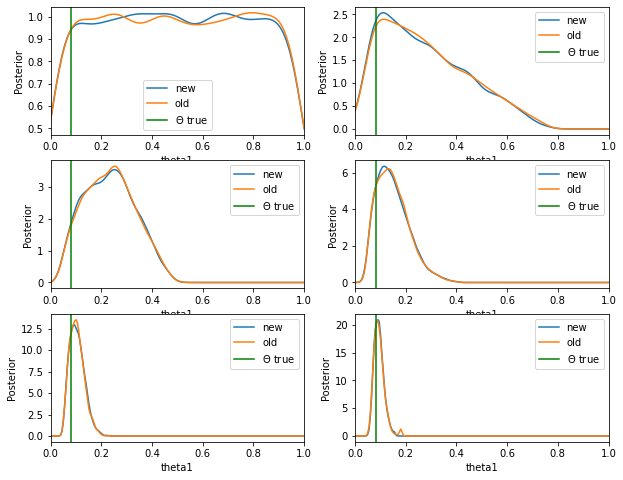

In [15]:
fig = plt.figure(figsize=(10,8))
for t in range(h.max_t+1):
    ax = fig.add_subplot(3, np.ceil(h.max_t / 3), t+1)

    ax = pyabc.visualization.plot_kde_1d(
        *h.get_distribution(m=0, t=t), "theta1", xmin=0, xmax=1, numx=200, ax=ax, label="new")
    ax = pyabc.visualization.plot_kde_1d(
        *h_old.get_distribution(m=0,t=t), "theta1", xmin=0, xmax=1, numx=200, ax=ax, label = "old")
    plt.axvline(x=theta1_true, color='g', label='$\Theta$ true')
    ax.legend()

fig.tight_layout()
plt.savefig("/home/felipe/MTGraphics/Theta1Development.jpg")

ValueError: num must be 1 <= num <= 6, not 7

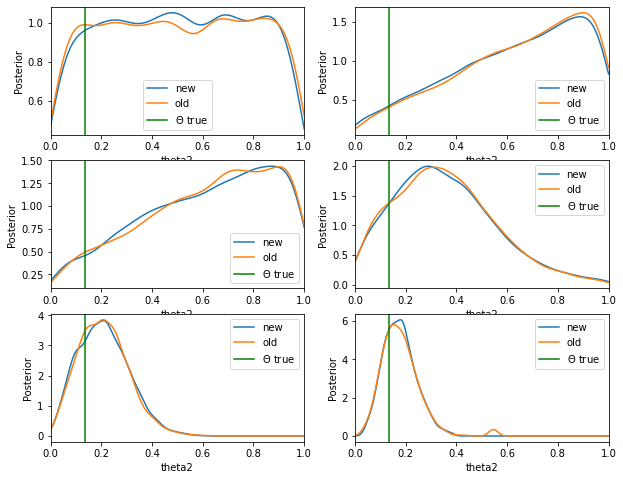

In [16]:
fig = plt.figure(figsize=(10,8))
for t in range(h.max_t+1):
    ax = fig.add_subplot(3, np.ceil(h.max_t / 3), t+1)

    ax = pyabc.visualization.plot_kde_1d(
        *h.get_distribution(m=0, t=t), "theta2", xmin=0, xmax=1, numx=200, ax=ax, label="new")
    ax = pyabc.visualization.plot_kde_1d(
        *h_old.get_distribution(m=0,t=t), "theta2", xmin=0, xmax=1, numx=200, ax=ax, label = "old")
    plt.axvline(x=theta2_true, color='g', label='$\Theta$ true')
    ax.legend()
    
fig.tight_layout()
plt.savefig("/home/felipe/MTGraphics/Theta2Development.jpg")

We can also plot the simulated trajectories:

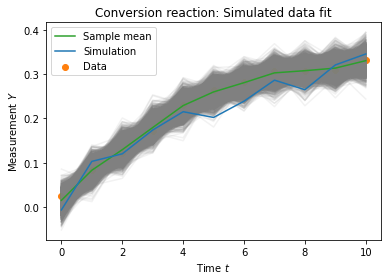

In [17]:
_, ax = plt.subplots()

def plot_data(sum_stat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    ax.plot(measurement_times, sum_stat['X_2'], color='grey', alpha=0.1)
    
def plot_mean(sum_stats, weights, ax, **kwargs):
    """Plot mean over all samples"""
    weights = np.array(weights)
    weights /= weights.sum()
    data = np.array([sum_stat['X_2'] for sum_stat in sum_stats])
    mean = (data * weights.reshape((-1, 1))).sum(axis=0)
    ax.plot(measurement_times, mean, color='C2', label='Sample mean')
    
ax = pyabc.visualization.plot_data_callback(h, plot_data, plot_mean, ax=ax)

plt.plot(true_trajectory, color="C0", label='Simulation')
plt.scatter(measurement_times, measurement_data,
            color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: Simulated data fit')
plt.legend()
plt.show()

In [ ]:
redis_sampler = pyabc.sampler.RedisEvalParallelSampler(host="localhost", port=6379, look_ahead = True)
abc = pyabc.ABCSMC(models=model,
             parameter_priors=parameter_prior,
             distance_function=distance,
             population_size=50,
             sampler=redis_sampler,
             transitions=pyabc.LocalTransition(k_fraction=.3),
             eps=eps)

iters = 100
means1 = np.zeros(iters)
means2 = np.zeros(iters)
runtimes = np.zeros(iters)
totalstarttime =time.time()
for i in range(0,iters):
    abc.new(db_path, {"X_2": measurement_data});
    start = time.time()
    h = abc.run(minimum_epsilon=0.1, max_nr_populations=5)
    end = time.time()
    kekse = h.get_distribution(m=0,t=h.max_t)
    npkekse1 = kekse[0][['theta1']].to_numpy()
    npkekse2 = kekse[0][['theta2']].to_numpy()
    means1[i] = npkekse1.mean()
    means2[i] = npkekse2.mean()
    runtimes[i] = end-start

totalendtime = time.time()
walltime = totalendtime-totalstarttime

In [ ]:
maxdist1=(abs(means1-theta1_true)).max()
plt.hist(means1,bins=50, range=(theta1_true-maxdist1,theta1_true+maxdist1))
plt.show()

In [ ]:
maxdist2=abs((means2-theta2_true)).max()
plt.hist(means2, bins=50, range=(theta2_true-maxdist2,theta2_true+maxdist2))
plt.show()

In [ ]:
print(runtimes.mean(), runtimes.var())
print(walltime)

In [ ]:
redis_sampler = pyabc.sampler.RedisEvalParallelSampler(host="localhost", port=6379, look_ahead = False)
abc = pyabc.ABCSMC(models=model,
             parameter_priors=parameter_prior,
             distance_function=distance,
             population_size=50,
             sampler=redis_sampler,
             transitions=pyabc.LocalTransition(k_fraction=.3),
             eps=eps)

iters = 20
means1 = np.zeros(iters)
means2 = np.zeros(iters)
runtimes = np.zeros(iters)
totalstarttime =time.time()
for i in range(0,iters):
    abc.new(db_path, {"X_2": measurement_data});
    start = time.time()
    h = abc.run(minimum_epsilon=0.1, max_nr_populations=len(eps_list))
    end = time.time()
    kekse = h.get_distribution(m=0,t=h.max_t)
    npkekse1 = kekse[0][['theta1']].to_numpy()
    npkekse2 = kekse[0][['theta2']].to_numpy()
    means1[i] = npkekse1.mean()
    means2[i] = npkekse2.mean()
    runtimes[i] = end-start

totalendtime = time.time()
walltime = totalendtime-totalstarttime

In [ ]:
print(runtimes.mean(), runtimes.var())
print(walltime)